In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 11:25:27.057347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 11:25:28.680517: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 10500
end_idx = 11000
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(500, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(500, 96, 7)
(336000,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(500, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(500, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 11:25:38.176501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:84:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 11:25:41.481065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step
CPU time: 7293.651407980127 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

16/16 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.50583304 0.35571851 0.78270834 ... 0.29002083 0.95986544 0.7418383 ]
Fitness value of the best solution = 0.003971981882691391


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

16/16 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


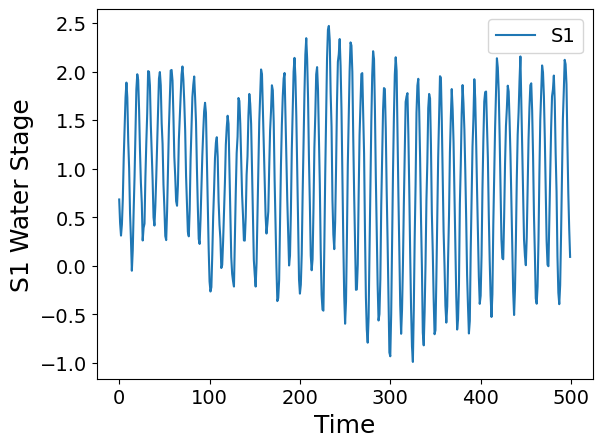

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low12.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.505833,0.355719,0.782708,0.990547,0.341758,0.666426,0.428108,0.978582,0.135905,0.970008,...,0.902337,0.617520,0.370879,0.776038,0.970686,0.529836,0.991057,0.325315,0.837279,0.513417
1,0.506779,0.744789,0.797724,0.931665,0.471854,0.499286,0.372614,0.694893,0.225722,0.113667,...,0.195986,0.882383,0.066041,0.213165,0.420505,0.316100,0.414206,0.255580,0.641223,0.219796
2,0.859968,0.867410,0.635341,0.804726,0.605442,0.016960,0.086715,0.195463,0.767241,0.545919,...,0.810148,0.872987,0.662280,0.949659,0.352483,0.644743,0.733591,0.811533,0.665063,0.004949
3,0.037889,0.128770,0.740874,0.612522,0.000146,0.761160,0.718153,0.303407,0.166082,0.108725,...,0.684365,0.242918,0.187466,0.141116,0.546101,0.566062,0.257092,0.410462,0.790370,0.917677
4,0.046913,0.546128,0.919441,0.362505,0.060566,0.373122,0.551530,0.972970,0.595468,0.854069,...,0.135104,0.296564,0.857056,0.040806,0.186666,0.150582,0.250613,0.502597,0.224844,0.219564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.639936,0.155256,0.159094,0.249669,0.860238,0.704409,0.807860,0.797090,0.983936,0.664202,...,0.339456,0.171374,0.148838,0.701063,0.373972,0.518180,0.670505,0.069891,0.794022,0.578934
496,0.691172,0.052745,0.102070,0.060751,0.778962,0.868678,0.818310,0.916788,0.029626,0.060393,...,0.366696,0.425337,0.509375,0.682309,0.117142,0.032735,0.354690,0.576373,0.325099,0.100927
497,0.343337,0.041065,0.212870,0.256798,0.361976,0.698876,0.209910,0.175844,0.188920,0.303609,...,0.094171,0.252804,0.084240,0.782120,0.011261,0.797933,0.039425,0.395705,0.055260,0.623604
498,0.849113,0.500828,0.254240,0.026214,0.914090,0.961921,0.664336,0.359919,0.722165,0.034070,...,0.838674,0.185854,0.714895,0.024589,0.228856,0.335614,0.333748,0.909363,0.098312,0.213974


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low12.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.682571,0.773979,0.844966,0.799948,0.394670,0.854846,0.536433,0.540174,0.269133,0.291802,...,1.729639,1.825145,1.531081,1.485054,1.669815,1.807182,1.212412,1.423098,1.497899,1.466592
1,0.440031,0.604790,0.531428,0.459633,0.230822,0.449917,0.186688,0.244207,0.442437,0.445259,...,1.525996,1.601517,1.101766,1.323456,1.305481,1.298091,0.919792,0.879275,1.125197,1.057612
2,0.310851,0.703072,0.409045,0.307205,0.333599,0.448696,0.392538,0.339553,0.659106,0.519493,...,1.327654,1.365319,0.986669,0.977979,1.266717,1.228314,0.586031,0.888770,0.924584,0.818469
3,0.426255,0.471857,0.477336,0.425320,0.716887,0.583991,0.703933,0.714580,1.112969,1.208033,...,1.154424,1.082015,0.626269,0.529250,0.909585,0.787599,0.389465,0.381756,0.680533,0.553396
4,0.686539,0.712611,0.806981,0.766453,1.036532,1.070185,1.086192,1.115718,1.517379,1.500821,...,0.821617,0.705151,0.231402,0.377521,0.472567,0.372573,0.174172,0.210661,0.367996,0.350070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.867687,1.888404,1.897452,1.905750,1.257046,1.270760,1.256377,1.251337,0.905677,1.217950,...,1.562630,1.640875,2.032183,2.082449,1.945741,2.125293,2.392992,2.521274,2.377137,2.513124
496,1.267175,1.543093,1.303282,1.301029,0.872556,0.756728,0.889622,0.914076,0.436585,0.725291,...,2.149420,2.270952,2.353860,2.170488,2.254848,2.407211,2.399410,2.510039,2.278011,2.459598
497,0.749377,0.853685,0.788023,0.736304,0.355699,0.125421,0.365167,0.303345,0.223496,0.321461,...,2.256827,2.454867,2.351592,2.285801,2.359792,2.511521,2.078195,2.179602,2.054022,2.160985
498,0.379538,0.125958,0.349740,0.341231,0.156151,0.263043,0.193179,0.162497,0.228698,0.383806,...,2.292563,2.425288,2.159625,2.165163,2.161509,2.314937,1.584736,1.534916,1.641079,1.683539


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 5155, areas: 1292.2998808048542


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

16/16 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 8776, areas: 3589.346129335854
